## Taller en Clase: Pronóstico del Número de Ocupados
### Objetivo del taller:

Empleando la información del número de ocupados (en miles de personas) para las 13 principales ciudades del país, construya un modelo de pronóstico para los próximos 6 meses utilizando los métodos de suavización exponencial vistos en clase, considerando versiones aditivas o multiplicativas según la naturaleza de la serie. Para ajustar los hiperparámetros del modelo (como alpha, beta y gamma), utilice optimización bayesiana a través de la librería Optuna, definiendo un espacio de búsqueda adecuado. La evaluación del modelo debe realizarse mediante un protocolo de validación temporal, utilizando una ventana móvil o recursiva, y empleando métricas apropiadas como RMSE.

Una vez ajustado el modelo, compárelo con el mejor modelo obtenido en el ejercicio anterior. Luego, elabore un informe breve (máximo una página de texto) explicando  los resultados obtenidos y las proyecciones generadas, incluyendo las predicciones para los próximos 6 meses, mencione las principales limitaciones del pronóstico.


In [75]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import warnings
import optuna



In [76]:
# Configuración de gráficos
import matplotlib.pyplot as plt

# Configuración matplotlib para el proyecto
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Montserrat', 'Arial', 'DejaVu Sans', 'Liberation Sans'],
    'figure.figsize': (12, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.75,
    'grid.alpha': 0.3,
    'axes.facecolor': '#fafcff',  # Azul hielo muy suave (Alice Blue)
    'axes.edgecolor': "#2E86AB",  # Azul océano principal
    'axes.prop_cycle': plt.cycler(color=[
        '#1F77B4',  # Azul matplotlib
        '#FF7F0E',  # Naranja matplotlib
        '#2CA02C',  # Verde matplotlib
        '#D62728',  # Rojo matplotlib
        '#9467BD',  # Púrpura matplotlib
        '#8C564B'   # Marrón matplotlib
    ])
})


# Carga de datos

In [77]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

TD_13ciudades  Ocupados  Desocupados  Inactivos
mes                                                        
2001-01-01      20.946380  6923.604     1834.507   4600.718
2001-02-01      19.894213  7037.746     1747.820   4596.805
2001-03-01      19.221565  6945.973     1652.823   4807.120
2001-04-01      17.888575  6973.079     1519.137   4937.280
2001-05-01      17.945654  6994.462     1529.720   4928.911

(222, 4)


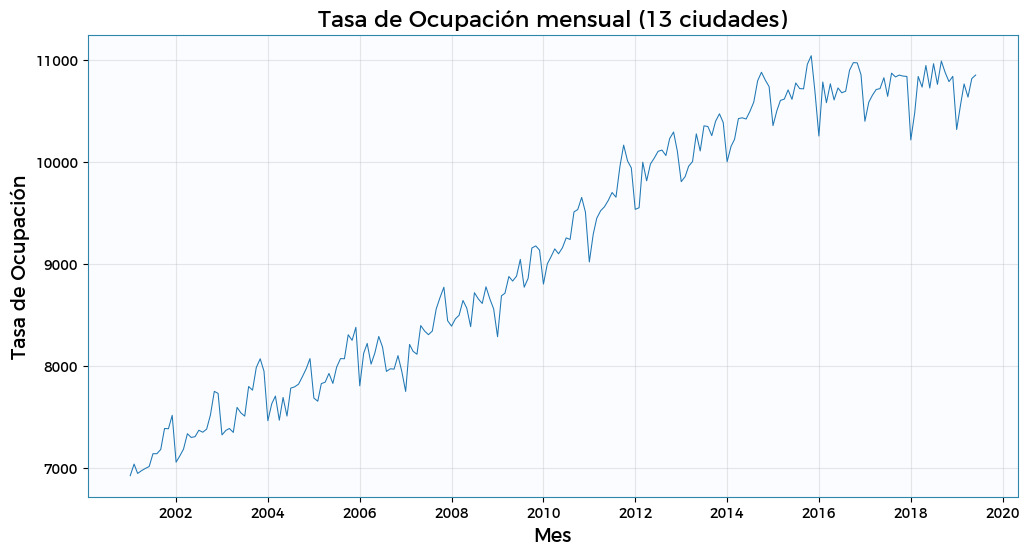

In [78]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de Ocupación mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de Ocupación")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

In [159]:
def evaluar_rolling_forecast_holtwinters(serie, alpha, beta, gamma, seasonal='add', trend='add',
                                          window_size=60, window=12, step_size=1, 
                                          horizon=6, metric='rmse'):
    """
    Evalúa el rendimiento de un modelo Holt-Winters usando validación cruzada con ventana móvil.
    
    La función simula el proceso de pronóstico en tiempo real, donde en cada iteración:
    1. Se usa una ventana fija de datos históricos para entrenar
    2. Se predice un horizonte fijo hacia el futuro
    3. Se comparan las predicciones con los valores reales observados
    4. La ventana se "desliza" al siguiente período

    Parámetros:
        serie       : Serie temporal de datos históricos
        alpha       : Suavización del nivel (0-1). Controla qué tan rápido se adapta a cambios
        beta        : Suavización de tendencia (0-1). Controla sensibilidad a cambios de pendiente
        gamma       : Suavización estacional (0-1). Controla adaptación a patrones estacionales
        seasonal    : Tipo de estacionalidad ('add' aditiva, 'mul' multiplicativa)
        window_size : Tamaño fijo de la ventana móvil para entrenamiento (ej: 60 meses)
        window      : Número de pronósticos a evaluar (desde el final hacia atrás)
        step_size   : Cada cuántos puntos avanza la ventana (1 = cada mes)
        horizon     : Cuántos períodos hacia adelante predecir en cada iteración
        metric      : Métrica de error ('rmse' o 'mae')

    Retorna:
        float: Error promedio entre todas las predicciones vs valores reales observados
    """
    
    # Preparación inicial: limpiar datos y definir puntos de evaluación
    serie = pd.Series(serie).astype(float).dropna()
    n = len(serie)
    predichos, observados = [], []
    
    # Definir dónde termina cada ventana de entrenamiento (desde el final hacia atrás)
    puntos_finales = list(range(n - window * step_size, n - horizon + 1, step_size))
    
    for i, end_train in enumerate(puntos_finales):
        # 1. Definir ventana móvil: siempre del mismo tamaño
        start_train = max(0, end_train - window_size)
        train = serie.iloc[start_train:end_train]
        test = serie.iloc[end_train:end_train + horizon]
        
        # 2. Validaciones básicas: datos suficientes y sin valores faltantes
        if len(test) < horizon or len(train) < 24 or test.isna().any() or train.isna().any():
            continue
            
        try:
            # 3. Entrenar modelo Holt-Winters con parámetros específicos
            model = ExponentialSmoothing(
                train, trend=trend, seasonal=seasonal, 
                seasonal_periods=12, initialization_method='estimated'
            ).fit(smoothing_level=alpha, smoothing_trend=beta, 
                  smoothing_seasonal=gamma, optimized=False)
            
            # 4. Generar pronósticos para el horizonte definido
            pred = pd.Series(model.forecast(steps=horizon)).astype(float)
            
            # 5. Filtrar predicciones válidas y acumular resultados
            mask = (~pred.isna()) & (~test.isna())
            if mask.sum() > 0:
                predichos.extend(pred[mask].tolist())
                observados.extend(test[mask].tolist())
                
        except Exception as e:
            # Continuar con la siguiente iteración si hay errores en el ajuste
            continue
    
    # Cálculo final del error promedio
    if len(predichos) == 0:
        return np.inf
        
    predichos, observados = np.array(predichos), np.array(observados)
    mask_finite = np.isfinite(predichos) & np.isfinite(observados)
    
    if mask_finite.sum() == 0:
        return np.inf
        
    predichos_clean = predichos[mask_finite]
    observados_clean = observados[mask_finite]
    
    # Retornar métrica solicitada
    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados_clean, predichos_clean))
    elif metric == 'mae':
        return np.mean(np.abs(observados_clean - predichos_clean))
    else:
        raise ValueError("Metric debe ser 'rmse' o 'mae'")

In [160]:
# Optimización con Optuna para Holt-Winters
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def objective_holtwinters(trial):
    """
    Función objetivo para optimización de Holt-Winters con Optuna
    """
    # Parámetros de suavización a optimizar
    alpha = trial.suggest_float("alpha", 0.001, 0.200)
    beta = trial.suggest_float("beta", 0.5, 0.6)
    gamma = trial.suggest_float("gamma", 0.5, 0.6)
    
    # Tipo de estacionalidad
    seasonal = trial.suggest_categorical("seasonal", ["add", "mul","none"])
    
    # Tipo de tendencia (NUEVO - para optimizar también)
    trend = trial.suggest_categorical("trend", ["add", "mul","none"])
    
    # Tamaño de ventana móvil
    window_size = trial.suggest_int("window_size", 6, 36)
    
    return evaluar_rolling_forecast_holtwinters(
        serie, alpha, beta, gamma, 
        seasonal=seasonal,
        trend=trend,
        window_size=window_size,
        window=12, 
        step_size=1, 
        horizon=6,
        metric='rmse'
    )

# Configuración de la serie para optimización
serie = data["Ocupados"]

# Crear y ejecutar estudio de optimización
study_hw = optuna.create_study(direction="minimize")
study_hw.optimize(objective_holtwinters, n_trials=1000)

print("Mejores parámetros encontrados:")
print(study_hw.best_params)
print(f"Mejor RMSE: {study_hw.best_value:.4f}")

[I 2025-11-15 18:51:20,764] A new study created in memory with name: no-name-ed18c0e4-80e6-4dec-8e9b-129645519193
[I 2025-11-15 18:51:20,828] Trial 0 finished with value: inf and parameters: {'alpha': 0.11603645406088037, 'beta': 0.5765126422062492, 'gamma': 0.5866997193510125, 'seasonal': 'none', 'trend': 'mul', 'window_size': 16}. Best is trial 0 with value: inf.
[I 2025-11-15 18:51:21,122] Trial 1 finished with value: 111.19829724179522 and parameters: {'alpha': 0.058419504490535956, 'beta': 0.5157729414621839, 'gamma': 0.5321263185446968, 'seasonal': 'add', 'trend': 'mul', 'window_size': 27}. Best is trial 1 with value: 111.19829724179522.
[I 2025-11-15 18:51:21,182] Trial 2 finished with value: 218.32665662099788 and parameters: {'alpha': 0.1227017228083056, 'beta': 0.5348768660879466, 'gamma': 0.5037297840865708, 'seasonal': 'mul', 'trend': 'mul', 'window_size': 30}. Best is trial 1 with value: 111.19829724179522.
[I 2025-11-15 18:51:21,245] Trial 3 finished with value: 287.94302

Mejores parámetros encontrados:
{'alpha': 0.009157286394748795, 'beta': 0.5313450442624632, 'gamma': 0.5235094279718682, 'seasonal': 'add', 'trend': 'add', 'window_size': 30}
Mejor RMSE: 76.5682


In [161]:
# Resultados de optimización Holt-Winters
print("="*60)
print("RESULTADOS DE OPTIMIZACIÓN HOLT-WINTERS")
print("="*60)

if 'study_hw' in locals():
    print(f"Mejor RMSE obtenido: {study_hw.best_value:.4f}")
    print(f"\nMejores parámetros encontrados:")
    for param, value in study_hw.best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    
    print(f"\nNúmero de trials ejecutados: {len(study_hw.trials)}")
    print(f"Número de trials exitosos: {len([t for t in study_hw.trials if t.state.name == 'COMPLETE'])}")
else:
    print("Optimización no ejecutada aún. Ejecutar la celda anterior primero.")

print("="*60)

RESULTADOS DE OPTIMIZACIÓN HOLT-WINTERS
Mejor RMSE obtenido: 76.5682

Mejores parámetros encontrados:
  alpha: 0.0092
  beta: 0.5313
  gamma: 0.5235
  seasonal: add
  trend: add
  window_size: 30

Número de trials ejecutados: 1000
Número de trials exitosos: 1000


In [162]:
# Modelo final con mejores parámetros
best_params = study_hw.best_params
serie_completa = pd.Series(data["Ocupados"]).astype(float).dropna()


In [164]:
best_params

{'alpha': 0.009157286394748795,
 'beta': 0.5313450442624632,
 'gamma': 0.5235094279718682,
 'seasonal': 'add',
 'trend': 'add',
 'window_size': 30}

In [168]:
# Entrenar modelo final
modelo_final = ExponentialSmoothing(
    serie_completa,
    trend=best_params['trend'],
    seasonal=best_params['seasonal'],
    seasonal_periods=best_params['window_size'],
    initialization_method='estimated'
).fit(
    smoothing_level=best_params['alpha'],
    smoothing_trend=best_params['beta'],
    smoothing_seasonal=best_params['gamma'],
    optimized=False
)

print("Modelo final entrenado con los mejores parámetros")

Modelo final entrenado con los mejores parámetros


In [169]:
# Generar pronósticos para 6 meses
pronostico = modelo_final.forecast(steps=6)

# Crear fechas futuras
ultima_fecha = serie_completa.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(months=1), periods=6, freq='MS')

# Intervalos de confianza aproximados
error_std = study_hw.best_value
intervalo_inferior = pronostico - 1.96 * error_std
intervalo_superior = pronostico + 1.96 * error_std

print("Pronósticos generados para 6 meses")

Pronósticos generados para 6 meses


In [170]:
# Tabla de pronósticos
pronostico_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Pronóstico': pronostico.round(2),
    'Lím. Inferior': intervalo_inferior.round(2),
    'Lím. Superior': intervalo_superior.round(2)
})

print("="*60)
print("PRONÓSTICOS PARA LOS PRÓXIMOS 6 MESES")
print("="*60)
print(pronostico_df.to_string(index=False))
print("="*60)

PRONÓSTICOS PARA LOS PRÓXIMOS 6 MESES
     Fecha  Pronóstico  Lím. Inferior  Lím. Superior
2019-07-01    10516.54       10366.46       10666.61
2019-08-01    10618.70       10468.63       10768.78
2019-09-01    10744.68       10594.60       10894.75
2019-10-01    10774.87       10624.80       10924.94
2019-11-01    10772.11       10622.04       10922.19
2019-12-01    10800.85       10650.77       10950.92


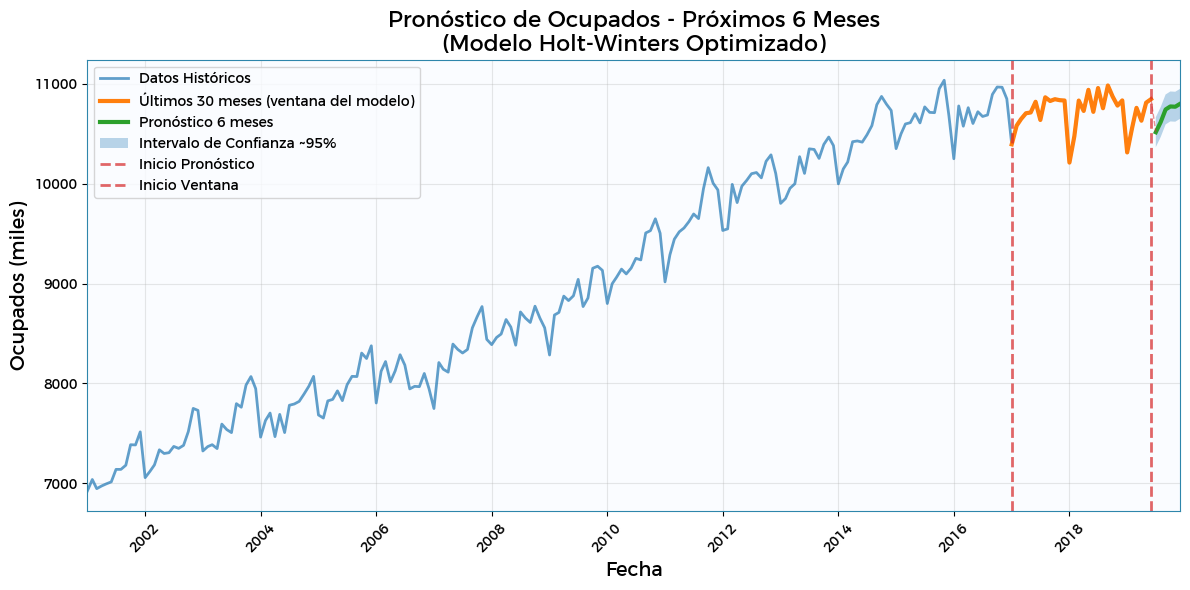

In [ ]:
# Serie histórica completa
plt.plot(serie_completa.index, serie_completa.values, label='Datos Históricos', linewidth=2, alpha=0.7)

# Resaltar últimos meses usando la misma ventana del modelo para consistencia
ventana_modelo = best_params['window_size']  # Usar la ventana optimizada
serie_reciente = serie_completa[-ventana_modelo:]
plt.plot(serie_reciente.index, serie_reciente.values, linewidth=3, alpha=1.0,
         label=f'Últimos {ventana_modelo} meses (ventana del modelo)')

# Pronóstico
plt.plot(fechas_futuras, pronostico, label='Pronóstico 6 meses', linewidth=3, markersize=6)

# Intervalo de confianza
plt.fill_between(fechas_futuras, intervalo_inferior, intervalo_superior, 
                alpha=0.3, label='Intervalo de Confianza ~95%')


# Línea divisoria
plt.axvline(x=ultima_fecha, linestyle='--', color='#D62728',alpha=0.7, linewidth=2, label='Inicio Pronóstico')
plt.axvline(x=serie_reciente.index[0], linestyle='--', color='#D62728',alpha=0.7, linewidth=2, label='Inicio Ventana')

# Conectar último punto con primer pronóstico
plt.plot([ultima_fecha, fechas_futuras[0]], [serie_completa.iloc[-1], pronostico.iloc[0]], 
        linestyle='--', alpha=0.5, linewidth=1)

plt.title('Pronóstico de Ocupados - Próximos 6 Meses\n(Modelo Holt-Winters Optimizado)')
plt.xlabel('Fecha')
plt.ylabel('Ocupados (miles)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.xlim(serie_completa.index[0], fechas_futuras[-1])

plt.tight_layout()
plt.show()

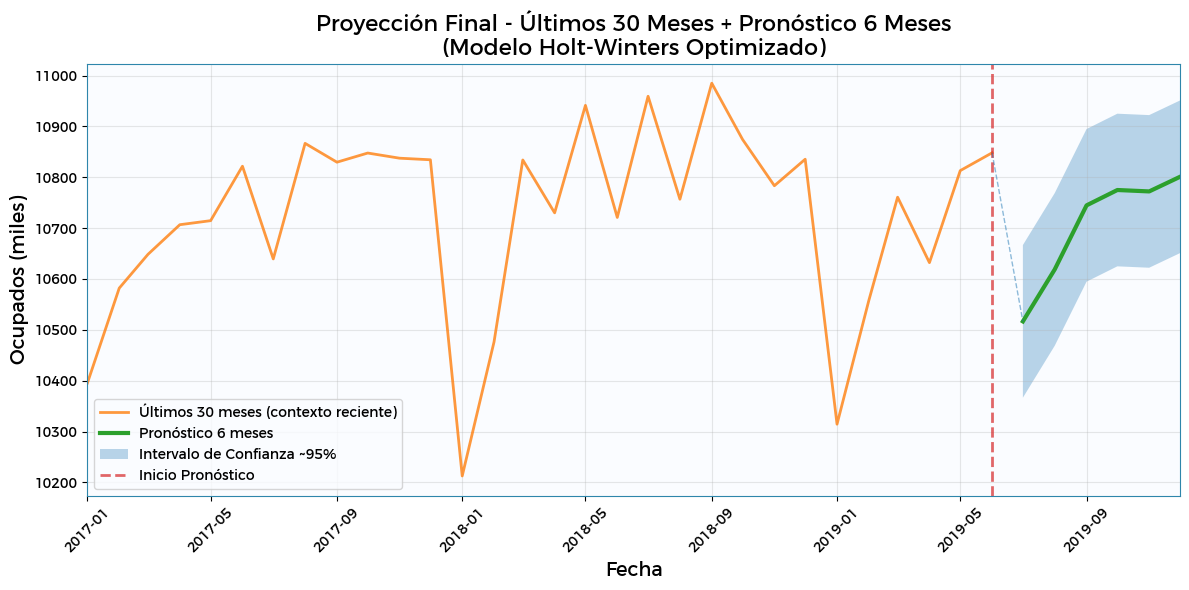

In [178]:
# Usar la ventana de predicción para visualización clara del contexto reciente
serie_reciente = serie_completa[-ventana_modelo:]
plt.plot(serie_reciente.index, serie_reciente.values, linewidth=2, alpha=0.8, color='#FF7F0E',
         label=f'Últimos {ventana_modelo} meses (contexto reciente)')

# Pronóstico
plt.plot(fechas_futuras, pronostico, label='Pronóstico 6 meses', color= '#2CA02C',linewidth=3, markersize=6)

# Intervalo de confianza
plt.fill_between(fechas_futuras, intervalo_inferior, intervalo_superior, 
                alpha=0.3, label='Intervalo de Confianza ~95%')

# Línea divisoria
plt.axvline(x=ultima_fecha, linestyle='--', alpha=0.7, color='#D62728', linewidth=2, label='Inicio Pronóstico')

# Conectar último punto con primer pronóstico
plt.plot([ultima_fecha, fechas_futuras[0]], [serie_completa.iloc[-1], pronostico.iloc[0]], 
        linestyle='--', alpha=0.5, linewidth=1)

plt.title(f'Proyección Final - Últimos {ventana_modelo} Meses + Pronóstico 6 Meses\n(Modelo Holt-Winters Optimizado)')
plt.xlabel('Fecha')
plt.ylabel('Ocupados (miles)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.xlim(serie_reciente.index[0], fechas_futuras[-1])

plt.tight_layout()
plt.show()

In [109]:
# Resumen del modelo optimizado
print(f"Parámetros del modelo final:")
print(f"  Alpha (nivel): {best_params['alpha']:.4f}")
print(f"  Beta (tendencia): {best_params['beta']:.4f}")
print(f"  Gamma (estacionalidad): {best_params['gamma']:.4f}")
print(f"  Tipo estacionalidad: {best_params['seasonal']}")
print(f"  Tamaño ventana: {best_params['window_size']}")
print(f"  RMSE validación: {study_hw.best_value:.4f}")

Parámetros del modelo final:
  Alpha (nivel): 0.0094
  Beta (tendencia): 0.5512
  Gamma (estacionalidad): 0.5834
  Tipo estacionalidad: add
  Tamaño ventana: 64
  RMSE validación: 77.4209


## Prueba con animación de la ventana movil ##

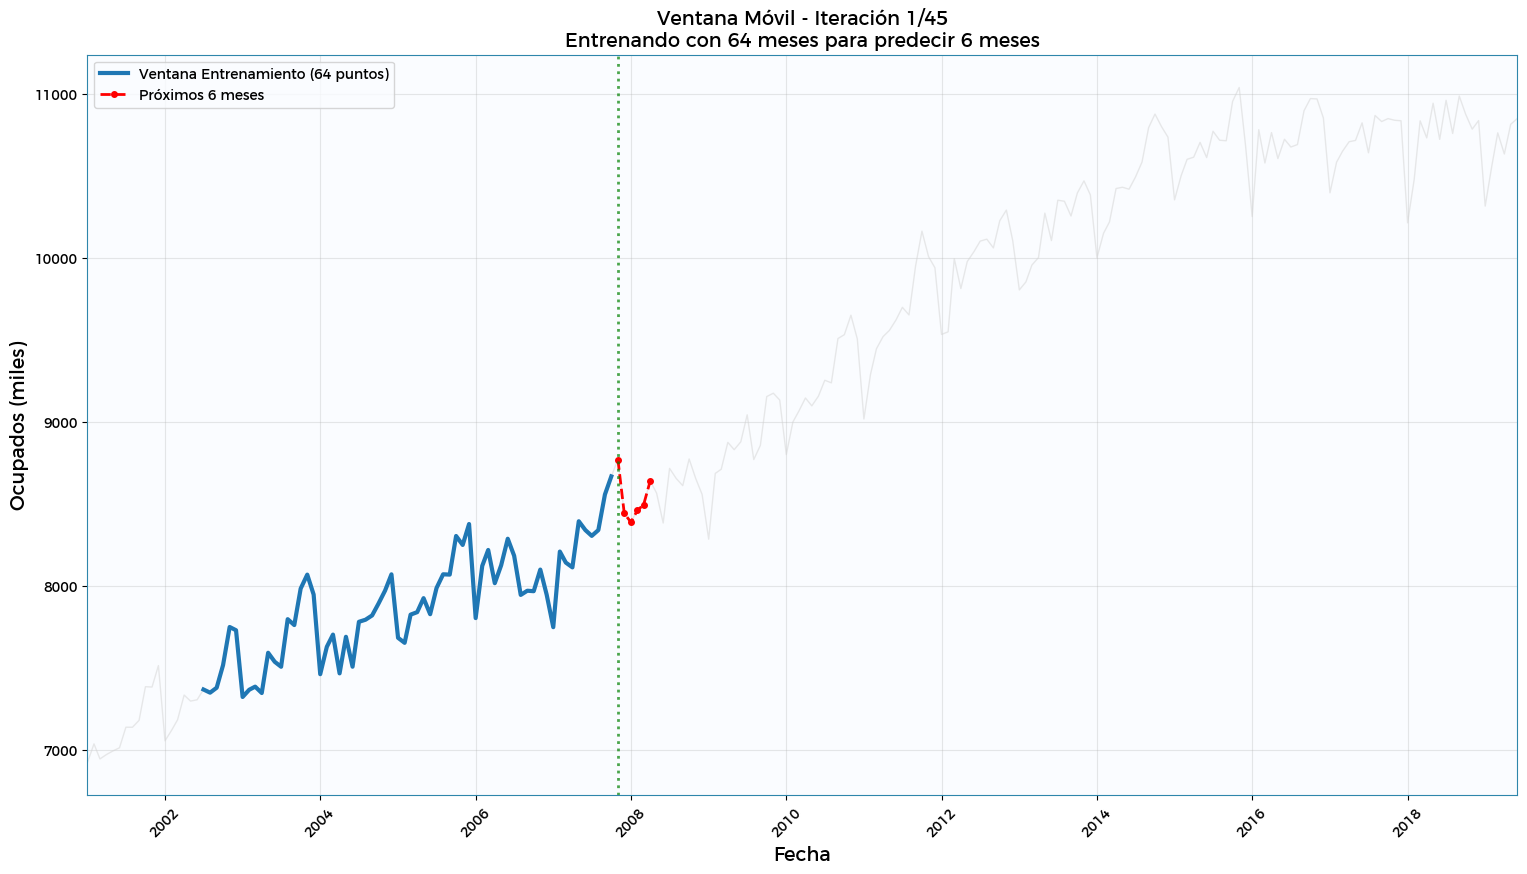

In [90]:
# Animación de ventana móvil
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

def crear_animacion_ventana():
    # Configuración para la animación
    window_size = best_params['window_size']
    horizon = 6
    window_count = 25  # Cuántas ventanas mostrar (más frames = animación más larga)
    step_size = 3      # Saltar cada 3 meses para animación más rápida
    
    n = len(serie_completa)
    # Empezar desde el inicio (mes window_size + horizon) para que se vea toda la evolución
    inicio_animacion = window_size + horizon + 12  # +12 para dar margen
    puntos_finales = list(range(inicio_animacion, n - horizon + 1, step_size))
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    def animate(frame):
        ax.clear()
        
        end_train = puntos_finales[frame]
        start_train = max(0, end_train - window_size)
        
        # Datos completos en gris claro
        ax.plot(serie_completa.index, serie_completa.values, 'lightgray', alpha=0.5, linewidth=1)
        
        # Ventana de entrenamiento actual
        train_window = serie_completa.iloc[start_train:end_train]
        ax.plot(train_window.index, train_window.values, linewidth=3, label=f'Ventana Entrenamiento ({len(train_window)} puntos)')
        
        # Próximos puntos a predecir
        test_window = serie_completa.iloc[end_train:end_train + horizon]
        if len(test_window) > 0:
            ax.plot(test_window.index, test_window.values, 'r--', linewidth=2, marker='o', 
                   markersize=4, label=f'Próximos {horizon} meses')
        
        # Línea divisoria
        ax.axvline(x=serie_completa.index[end_train], linestyle=':', alpha=0.7, linewidth=2, color='green')
        
        # Configuración del gráfico
        ax.set_title(f'Ventana Móvil - Iteración {frame + 1}/{len(puntos_finales)}\n'
                    f'Entrenando con {len(train_window)} meses para predecir {horizon} meses', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Ocupados (miles)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Mantener límites fijos
        ax.set_ylim(serie_completa.min() - 200, serie_completa.max() + 200)
        ax.set_xlim(serie_completa.index[0], serie_completa.index[-1])
        
        # Rotar fechas
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Crear animación
    # interval: velocidad en milisegundos (500=rápido, 1000=normal, 1500=lento)
    anim = FuncAnimation(fig, animate, frames=len(puntos_finales), interval=600, repeat=True)
    
    plt.tight_layout()
    return anim

# Generar la animación
animacion = crear_animacion_ventana()

# Mostrar en el notebook
HTML(animacion.to_jshtml())